# Linear Classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Help Functions

In [2]:
def read_file(file_name):
    
    with open(file_name, "r") as fp:
        fp_line = fp.read().split("\n")[:-1]
        
    fp_line = np.array([list(map(float, line.split())) for line in fp_line])
    
    X, Y = fp_line[:, :2], fp_line[:, -1].reshape((-1, 1))
    
    return X, Y.astype(int)

In [31]:
X, Y = read_file("classificationB.train")
TX, TY = read_file("classificationB.test")

## LDA

In [8]:
class lda:
    
    def __init__(self):
        # avoid evaluation before training
        self.flag_trained = False
        
    def train(self, X, Y):
        N, N1 = len(X), Y.sum()
        self.pi = float(N1) / N
        self.mu_0 = ((X * (1 - Y)).sum(0) / (N - N1)).reshape((1, 2))
        self.mu_1 = ((X * Y).sum(0) / N1).reshape((1, 2))
        var_elem = X - (1 - Y) * self.mu_0 - Y * self.mu_1
        self.sigma = np.matmul(var_elem.T, var_elem) / N
        self.inv_sigma = np.linalg.inv(self.sigma)
        # Training finished
        self.flag_trained = True
        self.find_boundary()
        
    def score(self, test_X, test_Y):
        N = len(test_X)
        pred_Y = self.test(test_X)
        err = float(np.abs(pred_Y - test_Y).sum()) / N
        print("The misclassification rate of the prediction is: %f" % err)
        
    def test(self, test_X):
        if self.flag_trained:
            N = len(test_X)
            avg_0, avg_1 = (test_X - self.mu_0), (test_X - self.mu_1) 
            pred_0, pred_1 = np.zeros((N, 3)), np.zeros((N, 3))
            pred_0[:, 0] = (avg_0[:, 0] ** 2) * self.inv_sigma[0, 0]
            pred_0[:, 1] = (avg_0[:, 1] ** 2) * self.inv_sigma[1, 1]
            pred_0[:, 2] = 2 * avg_0.prod(1) * self.inv_sigma[0, 1]
            pred_0 = np.exp(-0.5 * pred_0.sum(1)) * (1 - self.pi)

            pred_1[:, 0] = (avg_1[:, 0] ** 2) * self.inv_sigma[0, 0]
            pred_1[:, 1] = (avg_1[:, 1] ** 2) * self.inv_sigma[1, 1]
            pred_1[:, 2] = 2 * avg_1.prod(1) * self.inv_sigma[0, 1]
            pred_1 = np.exp(-0.5 * pred_1.sum(1)) * self.pi

            pred = (pred_1 >= pred_0).reshape((-1, 1)).astype(int)
            return pred
        else:
            print("Error! The classifier has not been trained yet!")
            
    def find_boundary(self):
        if self.flag_trained:
            c = np.log(1 - self.pi) - np.log(self.pi) + 0.5 * np.matmul(np.matmul(self.mu_1, self.inv_sigma), self.mu_1.T) - 0.5 * np.matmul(np.matmul(self.mu_0, self.inv_sigma), self.mu_0.T)
            # find (0, b)
            self.zero_x = float(np.squeeze(c / np.matmul(self.mu_1 - self.mu_0, self.inv_sigma[1].reshape((-1, 1)))))
            # find (a, 0)
            self.zero_y = float(np.squeeze(c / np.matmul(self.mu_1 - self.mu_0, self.inv_sigma[0].reshape((-1, 1)))))
            self.k = -self.zero_x / self.zero_y
        else:
            print("Error! The classifier has not been trained yet!")

In [49]:
my_lda = lda()
my_lda.train(X, Y)
print("---Train---")
my_lda.score(X, Y)
print("---Test---")
my_lda.score(TX, TY)

---Train---
The misclassification rate of the prediction is: 0.030000
---Test---
The misclassification rate of the prediction is: 0.041500


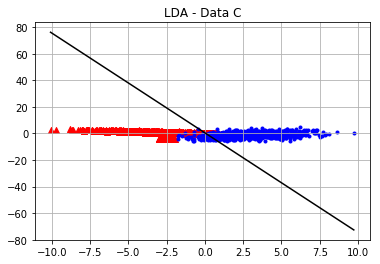

In [10]:
xmin, xmax = TX[:, 0].min(), TX[:, 0].max()
plt.figure()
plt.scatter(TX[TY.reshape((-1)) == 1, 0], TX[TY.reshape((-1)) == 1, 1], marker = '^', c = "r")
plt.scatter(TX[TY.reshape((-1)) == 0, 0], TX[TY.reshape((-1)) == 0, 1], marker = '.', c = "b")
plt.plot([xmin, xmax], [my_lda.k * xmin + my_lda.zero_x, my_lda.k * xmax + my_lda.zero_x], c = "black")
plt.title("LDA - Data C")
plt.grid()
plt.show()

## Logistic Regression

In [11]:
def sigmoid(x, w, derivative = False):
    
    z = np.matmul(x, w)
    
    return z * (1 - z) if derivative else 1 / (1 + np.exp(-z))

In [12]:
def logistic_loss(x, y, w):
    
    x_sigmoid = sigmoid(x, w)
    
    return (y * np.log(x_sigmoid) + (1 - y) * np.log(1 - x_sigmoid)).sum()

In [13]:
def calc_gradient(x, y, w):
    
    return ((y - sigmoid(x, w)) * x).sum(0)

In [45]:
def calc_hessian(x, w):
    
    return np.matmul(np.matmul(x.T, np.diagflat(sigmoid(x, w, True))), x)

In [46]:
class logistic_regression:
    
    def __init__(self, max_iter = 3000, threshold = 1e-5):
        self.max_iter = max_iter
        self.threshold = threshold
        # avoid evaluation before training
        self.flag_trained = False
        
    def train(self, X, Y):
        X = np.hstack((X, np.ones((len(X), 1))))
        self.W = np.random.randn(X.shape[1], 1)
        self.llose = [np.infty, logistic_loss(X, Y, self.W)]
        counter = 0
        
        while (counter < self.max_iter) and (np.abs(self.llose[-1] - self.llose[-2]) > self.threshold):
            H = calc_hessian(X, self.W)
            G = calc_gradient(X, Y, self.W)
            self.W = self.W - np.matmul(np.linalg.inv(H), G.reshape((-1, 1)))
            self.llose.append(logistic_loss(X, Y, self.W))
            counter += 1
            
        self.flag_trained = True
            
        
    def score(self, test_X, test_Y):
        N = len(test_X)
        pred_Y = self.test(test_X)
        err = float(np.abs(pred_Y - test_Y).sum()) / N
        print("The misclassification rate of the prediction is: %f" % err)
        
        
    def test(self, test_X):
        if self.flag_trained:
            test_X = np.hstack((test_X, np.ones((len(test_X), 1))))
            pred = (sigmoid(test_X, self.W) > 0.5).astype(int)
            return pred
        else:
            print("Error! The classifier has not been trained yet!")

In [50]:
logist = logistic_regression()
logist.train(X, Y)
print("---Train---")
logist.score(X, Y)
print("---Test---")
logist.score(TX, TY)

---Train---
The misclassification rate of the prediction is: 0.020000
---Test---
The misclassification rate of the prediction is: 0.038500


In [40]:
logist.W

array([[-1.16082232],
       [ 0.65229086],
       [ 0.63539313]])

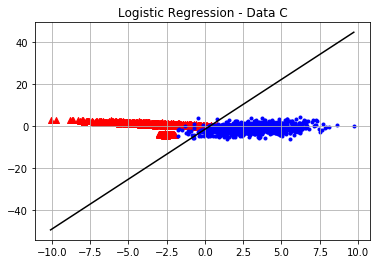

In [202]:
xmin, xmax = TX[:, 0].min(), TX[:, 0].max()
plt.figure()
plt.scatter(TX[TY.reshape((-1)) == 1, 0], TX[TY.reshape((-1)) == 1, 1], marker = '^', c = "r")
plt.scatter(TX[TY.reshape((-1)) == 0, 0], TX[TY.reshape((-1)) == 0, 1], marker = '.', c = "b")
plt.plot([xmin, xmax], [- (logist.W[0, 0] * xmin + logist.W[2, 0]) / logist.W[1, 0] , - (logist.W[0, 0] * xmax + logist.W[2, 0]) / logist.W[1, 0]], c = "black")
plt.title("Logistic Regression - Data C")
plt.grid()
plt.show()

## Linear Regression

In [25]:
class linear_regression:
    
    def __init__(self):
        # avoid evaluation before training
        self.flag_trained = False
        
    def train(self, X, Y):
        X = np.hstack((X, np.ones((len(X), 1))))
        xtx_inv = np.linalg.inv(np.matmul(X.T, X))
        self.A = np.matmul(np.matmul(xtx_inv, X.T), Y)
        self.flag_trained = True
            
    def score(self, test_X, test_Y):
        N = len(test_X)
        pred_Y = self.test(test_X)
        err = float(np.abs(pred_Y - test_Y).sum()) / N
        print("The misclassification rate of the prediction is: %f" % err)
        
    def test(self, test_X):
        if self.flag_trained:
            test_X = np.hstack((test_X, np.ones((len(test_X), 1))))
            pred = (np.matmul(test_X, self.A) > 0.5).astype(int)
            return pred
        else:
            print("Error! The classifier has not been trained yet!")

In [51]:
linerg = linear_regression()
linerg.train(X, Y)
print("---Train---")
linerg.score(X, Y)
print("---Test---")
linerg.score(TX, TY)

---Train---
The misclassification rate of the prediction is: 0.030000
---Test---
The misclassification rate of the prediction is: 0.041500


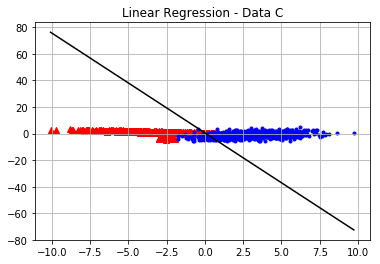

In [204]:
xmin, xmax = TX[:, 0].min(), TX[:, 0].max()
plt.figure()
plt.scatter(TX[TY.reshape((-1)) == 1, 0], TX[TY.reshape((-1)) == 1, 1], marker = '^', c = "r")
plt.scatter(TX[TY.reshape((-1)) == 0, 0], TX[TY.reshape((-1)) == 0, 1], marker = '.', c = "b")
plt.plot([xmin, xmax], [- (linerg.A[0, 0] * xmin + linerg.A[2, 0] - 0.5) / linerg.A[1, 0] , - (linerg.A[0, 0] * xmax + linerg.A[2, 0] - 0.5) / linerg.A[1, 0]], c = "black")
plt.title("Linear Regression - Data C")
plt.grid()
plt.show()

## QDA

In [27]:
class qda:
    
    def __init__(self):
        # avoid evaluation before training
        self.flag_trained = False
        
    def train(self, X, Y):
        N, N1 = len(X), Y.sum()
        self.pi = float(N1) / N
        self.mu_0 = ((X * (1 - Y)).sum(0) / (N - N1)).reshape((1, 2))
        self.mu_1 = ((X * Y).sum(0) / N1).reshape((1, 2))
        var_elem = X - (1 - Y) * self.mu_0 - Y * self.mu_1
        mask_1 = (Y.reshape((-1)) == 1)
        self.sigma_0 = np.matmul(var_elem[~mask_1].T, var_elem[~mask_1]) / (N - N1)
        self.sigma_1 = np.matmul(var_elem[mask_1].T, var_elem[mask_1]) / N1
        self.inv_sigma_0 = np.linalg.inv(self.sigma_0)
        self.inv_sigma_1 = np.linalg.inv(self.sigma_1)
        # Training finished
        self.flag_trained = True
        
    def score(self, test_X, test_Y):
        N = len(test_X)
        pred_Y = self.test(test_X)
        err = float(np.abs(pred_Y - test_Y).sum()) / N
        print("The misclassification rate of the prediction is: %f" % err)
        
    def test(self, test_X):
        if self.flag_trained:
            N = len(test_X)
            avg_0, avg_1 = (test_X - self.mu_0), (test_X - self.mu_1) 
            pred_0, pred_1 = np.zeros((N, 3)), np.zeros((N, 3))
            pred_0[:, 0] = (avg_0[:, 0] ** 2) * self.inv_sigma_0[0, 0]
            pred_0[:, 1] = (avg_0[:, 1] ** 2) * self.inv_sigma_0[1, 1]
            pred_0[:, 2] = 2 * avg_0.prod(1) * self.inv_sigma_0[0, 1]
            pred_0 = np.exp(-0.5 * pred_0.sum(1)) * (1 - self.pi)

            pred_1[:, 0] = (avg_1[:, 0] ** 2) * self.inv_sigma_1[0, 0]
            pred_1[:, 1] = (avg_1[:, 1] ** 2) * self.inv_sigma_1[1, 1]
            pred_1[:, 2] = 2 * avg_1.prod(1) * self.inv_sigma_1[0, 1]
            pred_1 = np.exp(-0.5 * pred_1.sum(1)) * self.pi

            pred = (pred_1 >= pred_0).reshape((-1, 1)).astype(int)
            return pred
        else:
            print("Error! The classifier has not been trained yet!")
            
    def find_boundary(self, x):
        if self.flag_trained:
            c = np.log(np.linalg.det(self.sigma_0)) - np.log(np.linalg.det(self.sigma_1)) + 2 * np.log(self.pi) - 2 * np.log(1 - self.pi)
            u = self.inv_sigma_1[1, 1] - self.inv_sigma_0[1, 1]
            v = -2 * self.inv_sigma_1[1, 1] * self.mu_1[0, 1] + 2 * self.inv_sigma_0[1, 1] * self.mu_0[0, 1] \
                + 2 * self.inv_sigma_1[0, 1] * (x - self.mu_1[0, 0]) - 2 * self.inv_sigma_0[0, 1] * (x - self.mu_0[0, 0])
            w = c - self.inv_sigma_1[0, 0] * ((x - self.mu_1[0, 0]) ** 2) + self.inv_sigma_0[0, 0] * ((x - self.mu_0[0, 0]) ** 2) \
                + 2 * self.inv_sigma_1[0, 1] * self.mu_1[0, 1] * x - 2 * self.inv_sigma_0[0, 1] * self.mu_0[0, 1] * x \
                - self.inv_sigma_1[1, 1] * self.mu_1[0, 1] ** 2 + self.inv_sigma_0[1, 1] * self.mu_0[0, 1] ** 2 \
                - 2 * self.inv_sigma_1[0, 1] * self.mu_1.prod() + 2 * self.inv_sigma_0[0, 1] * self.mu_0.prod()
            det = v ** 2 + 4 * u * w
            mask = (det >= 0)
            y0 = (-v[mask] + np.sqrt(det[mask])) / (2 * u)
            y1 = (-v[mask] - np.sqrt(det[mask])) / (2 * u)
            return (x[mask], y0, y1)
        else:
            print("Error! The classifier has not been trained yet!")

In [52]:
my_qda = qda()
my_qda.train(X, Y)
print("---Train---")
my_qda.score(X, Y)
print("---Test---")
my_qda.score(TX, TY)

---Train---
The misclassification rate of the prediction is: 0.023333
---Test---
The misclassification rate of the prediction is: 0.023500


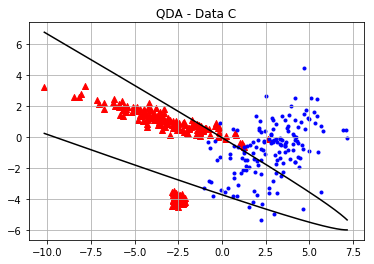

In [249]:
xmin, xmax = TX[:, 0].min(), TX[:, 0].max()
grid_x = np.arange(xmin, xmax, (xmax - xmin) / 1000)
grid_x, grid_y0, grid_y1 = my_qda.find_boundary(grid_x)
plt.figure()
plt.scatter(TX[TY.reshape((-1)) == 1, 0], TX[TY.reshape((-1)) == 1, 1], marker = '^', c = "r")
plt.scatter(TX[TY.reshape((-1)) == 0, 0], TX[TY.reshape((-1)) == 0, 1], marker = '.', c = "b")
plt.plot(grid_x, grid_y0, c = "black")
plt.plot(grid_x, grid_y1, c = "black")
plt.title("QDA - Data C")
plt.grid()
plt.show()